In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Declare Variables 

In [5]:
n_states = 5 #number of states in the GMM
n_in = 1 #Number of variables for the radial basis function [s] (decay term)
n_out = 2 # Number of motion variables [xi,x2]

n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

#### Load Data 

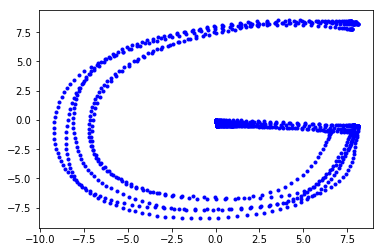

In [38]:
ROOT = 'python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[:n_samples]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')

In [7]:
def subsample(X,N):
    '''Subsample in N iterations the trajectory X. The output is a 
    trajectory similar to X with N points. '''
    nx  = X.shape[0]
    idx = np.arange(float(N))/(N-1)*(nx-1)
    hx  = []
    for i in idx:
        i0 = int(np.floor(i))
        i1 = int(np.ceil(i))
        di = i%1
        x  = X[i0,:]*(1-di) + X[i1,:]*di
        hx.append(x)
    return np.vstack(hx)

In [8]:
data2 = []
for i in range(2):
    data2.append(data[i])
    
for i in range(2,4):
    data2.append(subsample(data[i][100:200,:],200))
    
for i in range(4,5):
    data2.append(subsample(data[i][:100,:],200))

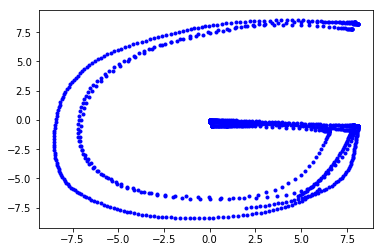

In [9]:
data2 = np.array(data2)
Y = np.concatenate(data2,axis=0)
plt.plot(Y[:,0], Y[:,1],'.b')

In [10]:
from scipy.stats import multivariate_normal as mvn

In [39]:
import numpy as np

In [40]:
hmm = HSMM(D= 2, K=6)

In [45]:
hmm.fit(data,init_type='kbins',n_init = 5,max_iter=60)

Iteration 0
-888.0222967620678
Iteration 1
-569.0987938520852
Iteration 2
-545.5535645153865
Iteration 3
-543.0466895994443
Iteration 4
-542.2748070724732
Iteration 5
-541.6546837680733
Iteration 6
-541.095990289668
Iteration 7
-540.5797786401105
Iteration 8
-540.087417602818
Iteration 9
-539.5462161240171
Iteration 10
-538.8213018268992
Iteration 11
-538.0902932026702
Iteration 12
-537.5740309556603
Iteration 13
-537.2090161969629
Iteration 14
-536.9398934320275
Iteration 15
-536.7357094931091
Iteration 16
-536.5761744854519
Iteration 17
-536.4475081343737
Iteration 18
-536.3405910542303
Iteration 19
-536.2494897699006
Iteration 20
-536.1703243931061
Iteration 21
-536.1004984424499
Iteration 22
-536.0382107561779
Iteration 23
-535.9821579778745
Iteration 24
-535.9313569199848
Iteration 25
-535.8850388661722
Iteration 26
-535.8425858260877
Iteration 27
-535.8034910982988
Iteration 28
-535.7673340332784
Iteration 29
-535.7337631323471
Iteration 30
-535.7024840011093
Iteration 31
-535.67

In [19]:
from utils import *

In [20]:
colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]

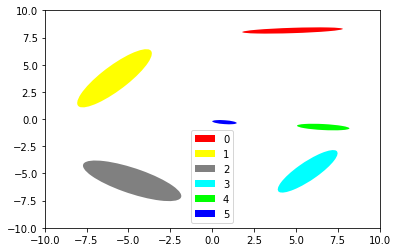

In [46]:
fig,ax = plt.subplots()
plot_GMM(hmm.means_, hmm.covariances_,ax,labels=['0','1','2','3','4','5'],colors=colors)
plt.axis([-10,10,-10,10])
#plt.plot(Y[:,0], Y[:,1],'.b',alpha=0.2)
plt.legend()

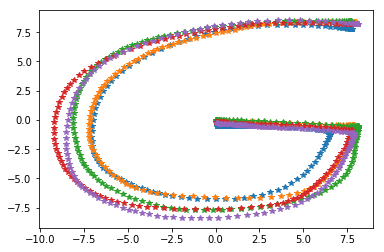

In [44]:
for x in hmm.xs:
    plt.plot(x[:,0],x[:,1],'*')

In [47]:
opt_seq = hmm.viterbi(hmm.xs[2])
print opt_seq

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log
/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:177: RuntimeWarning: divide by zero encountered in log


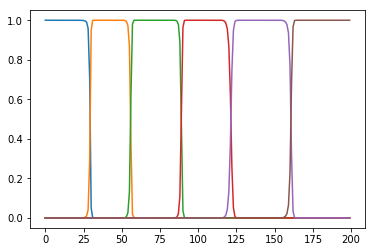

In [48]:
for i in range(hmm.K):
    plt.plot(hmm.alphas[4][:,i])

In [2]:
realmin = np.finfo(np.double).tiny
realmax = np.finfo(np.double).max

class HMM(GMM):
    def __init__(self, D = 1, K = 2,  reg_factor = 1e-6):
        self.D = D #number of dimensions
        self.K = K #number of mixture components
        self.L = -np.inf #total log likelihood
        self.weights_ = np.ones(K)/K
        self.means_ = np.random.rand(K,D)
        self.covariances_ = np.array([np.eye(D) for i in range(K)])
        self.reg_factor =  reg_factor 

    def init_kmeans(self):
        x = self.xs.reshape(-1,self.xs.shape[-1])
        kMM = KMeans(n_clusters=self.K).fit(x)
        self.means_ = kMM.cluster_centers_
        for i in range(self.K):
            self.covariances_[i] = np.cov(x[kMM.labels_==i].T) + np.eye(self.D)*self.reg_factor
        
    def init_random(self):
        self.means_ = self.x[np.random.choice(len(self.x),size = self.K)]
        for i in range(self.K):
            self.covariances_[i] = np.cov(self.x.T)
            
    def init_kbins(self):
        x = self.xs.reshape(-1,self.xs.shape[-1])
        tsep = np.linspace(0,self.N, self.K+1).astype(int)
        idx = []
        for k in range(self.K):
            idx.append(np.concatenate([m*self.N + np.arange(tsep[k],tsep[k+1]) for m in range(self.M)]))
            self.means_[k] = np.mean(x[idx[k]],axis=0)
            self.covariances_[k] = np.cov(x[idx[k]].T) + np.eye(self.D)*self.reg_factor
        
    def init_HMM(self):
        self.weights_ = np.ones(self.K)/self.K
        self.Trans_ =  np.ones((self.K,self.K))/self.K
            
    def fit(self,xs, max_iter = 10, init_type = 'kmeans', threshold = 1e-6, n_init = 5):
        self.xs = xs
        self.M = len(self.xs) #number of samples
        self.N = len(self.xs[0]) #number of datapoints

        self.threshold = threshold
        
        best_params = ()
        Lmax = -np.inf
        for it in range(n_init):
            if init_type == 'kmeans':
                self.init_kmeans()
            elif init_type == 'random':
                self.init_random()
            elif init_type == 'kbins':
                self.init_kbins()
                

            self.init_HMM()
            
            for i in range(max_iter):
                print 'Iteration ' + str(i)
                self.expectation()
                self.maximization()
                print self.L
                if np.abs(self.prev_L-self.L) < self.threshold:
                    break
                    
            if self.L > Lmax:
                Lmax = self.L
                best_params = (self.L, self.weights_.copy(), self.means_.copy(), self.covariances_.copy())
            
        #return the best result
        self.L = Lmax
        self.weights_ = best_params[1]
        self.means_ = best_params[2]
        self.covariances_ = best_params[3]
        print 'Obtain best result with Log Likelihood: ' + str(self.L)
        
    def expectation(self):
        self.prev_L = self.L

        self.alphas = np.zeros((self.M, self.N,self.K)) 
        self.betas = np.zeros((self.M, self.N,self.K))
        self.gammas = np.zeros((self.M, self.N,self.K))
        self.zetas = np.zeros((self.M, self.N,self.K, self.K))
        self.Bs = np.zeros((self.M,self.N,self.K))
        self.L = np.zeros(self.M)
        self.cs = np.zeros((self.M, self.N))
        
        for m in range(self.M):
            #compute emission probabilities
            
            for k in range(self.K):
                self.Bs[m][:,k] = mvn(mean=self.means_[k], cov=self.covariances_[k]).pdf(self.xs[m])
            
            #compute alpha
            self.alphas[m][0,:] = self.weights_ * self.Bs[m][0,:]
            self.cs[m][0] = 1./(np.sum(self.alphas[m][0])+realmin)
            self.alphas[m][0] *= self.cs[m][0]
            for n in range(1,self.N):
                self.alphas[m][n,:] = self.Bs[m][n,:]*np.dot(self.alphas[m][n-1,:], self.Trans_)
                self.cs[m][n] = 1./(np.sum(self.alphas[m][n])+realmin)
                self.alphas[m][n] *= self.cs[m][n]
                
                
            #compute beta
            self.betas[m][-1,:] = np.ones(self.K)*self.cs[m][-1]
            for n in range(self.N-1,0,-1):
                self.betas[m][n-1,:] = np.dot(self.betas[m][n,:]*self.Bs[m][n,:], self.Trans_.T)
                self.betas[m][n-1,:] = (self.betas[m][n-1,:]*self.cs[m][n-1])
                
                
            #compute likelihood
            #self.L[m] = np.sum(self.alphas[m][-1,:])
            #self.L[m] = np.sum(self.alphas[m][self.N/2,:]*self.betas[m][self.N/2,:])
            self.L[m] = -np.sum(np.log(self.cs[m]))
            
            #compute gamma
            for n in range(self.N):
                #self.gammas[m][n,:] = self.alphas[m][n,:]*self.betas[m][n,:]/self.L[m]
                self.gammas[m][n,:] = self.alphas[m][n,:]*self.betas[m][n,:]/np.sum(self.alphas[m][n,:]*self.betas[m][n,:])

            #compute zeta
            for n in range(self.N-1):
                for k in range(self.K):
                    self.zetas[m][n][k,:] = self.alphas[m][n,k]*self.Bs[m][n+1,:]*self.betas[m][n+1,:]*self.Trans_[k,:]

                       
        self.L = np.mean(self.L)
             
    def maximization(self):
        x_mat = self.xs.reshape(-1,self.xs.shape[-1])
        gamma_mat = self.gammas.reshape(-1,self.gammas.shape[-1])
        zeta_mat = self.zetas.reshape(-1,self.zetas.shape[-2], self.zetas.shape[-1])
        self.x_mat = x_mat
        self.gamma_mat = gamma_mat
        self.zeta_mat = zeta_mat
        
        for k in range(self.K):
            #update weights
            self.weights_[k] =  np.mean(self.gammas[:,0,k]/np.sum(self.gammas[:,0,:],axis=1)) 

            means_k = np.zeros(self.D)
            sigma_k = np.zeros((self.D,self.D))
            
            #self.means_[k,:] 
            #self.covariances_[k,:]         
            
            for m in range(self.M):
                #update mean
                means_k += np.dot(self.gammas[m][:,k].T, self.xs[m])

                #update covariance
                x_reduce_mean = self.xs[m]-self.means_[k,:]
                sigma_k += dot(np.multiply(x_reduce_mean.T, self.gammas[m][:,k][None,:]), x_reduce_mean) 
            
            self.means_[k,:] = means_k / np.sum(self.gammas[:,:,k])
            self.covariances_[k,:] = sigma_k/np.sum(self.gammas[:,:,k])        + np.eye(self.D)*self.reg_factor
        
        self.Trans_ = np.sum(zeta_mat,axis=0)
        for k in range(self.K):
            self.Trans_[k,:] /= np.sum(self.Trans_[k,:])
        #/np.sum(zeta_mat,axis=(0,2))[:,None]
        
    def viterbi(self,x):
        self.delta = np.zeros((x.shape[0],self.K))
        self.psi = np.zeros((x.shape[0]-1,self.K))
        self.B = np.zeros((x.shape[0],self.K))
        
        self.opt_seq = np.zeros(x.shape[0]).astype(int)
        #compute emmision probabilities
        for k in range(self.K):
            self.B[:,k] = mvn(mean=self.means_[k], cov=self.covariances_[k]).logpdf(x)

        #initialise at n=0
        self.delta[0,:] = np.log(self.weights_) + self.B[0,:]
        for n in range(1,x.shape[0]):
            temp_vals = np.log(self.Trans_) + self.delta[n-1,:][:,None]
            self.delta[n,:] = self.B[n,:] + np.max(temp_vals, axis=0)
            self.psi[n-1,:] = np.argmax(temp_vals,axis=0)
        
        #find the optimal sequence
        self.opt_seq[-1] = np.argmax(self.delta[-1,:])
        for n in range(x.shape[0]-1, 0, -1):
            self.opt_seq[n-1] = self.psi[n-1,self.opt_seq[n]]
        return self.opt_seq
    
        
    def plot(self):
        fig,ax = plt.subplots()
        plot_GMM(self.means_, self.covariances_, ax)
        

In [29]:
hmm.state_durs

{0: [35, 37, 45, 45, 51],
 1: [67],
 2: [29, 31, 31, 29, 26],
 3: [34, 45, 49, 44, 41],
 4: [35, 87, 75, 82, 82],
 5: []}

In [49]:
hmm.viterbi(hmm.xs[4])

/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log
/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:177: RuntimeWarning: divide by zero encountered in log


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])

In [51]:
hmm.compute_durations(hmm.xs)

/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log
/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:177: RuntimeWarning: divide by zero encountered in log


In [53]:
hmm.means_pd_

array([31.4, 29. , 30.2, 24.6, 39. , 45.8])

In [54]:
hmm.sigmas_pd_

array([  3.44,  26.8 ,   6.16,  21.44,   8.  , 115.76])

In [3]:
realmin = np.finfo(np.double).tiny
realmax = np.finfo(np.double).max

class HSMM(HMM):
    def compute_durations(self, xs):
        self.state_durs = dict()
        for k in range(self.K):
            self.state_durs[k] = []

        #compute the optimal state sequences for the data xs
        opt_seqs = []
        for x in xs:
            opt_seqs += [self.viterbi(x)]
        
        #compute the state duration for each sequence    
        for opt_seq in opt_seqs:
            cur_state = opt_seq[0]
            cur_count = 1
            for s in opt_seq[1:]:
                if cur_state == s:
                    cur_count += 1
                else:
                    self.state_durs[cur_state] += [cur_count]
                    cur_state = s
                    cur_count = 1
            #for the last state
            self.state_durs[cur_state] += [cur_count]
        
        #compute the duration probability as Gaussian Distribution for each state
        self.means_pd_ = np.zeros(self.K)
        self.sigmas_pd_ = np.zeros(self.K)
        for k in range(self.K):
            self.means_pd_[k] = np.mean(self.state_durs[k])
            self.sigmas_pd_[k] = np.var(self.state_durs[k])
            
    def compute_forward_messages_HSMM(self,x):
        #precompute duration probabilities at each time step
        num_dur_max = 2.*self.N/self.K #the number of maximum duration that will be considered
        self.Pd = np.zeros((self.K,num_dur_max))
        for k in range(self.K):
            self.Pd[k,:] = mvn(mean=self.means_pd_[k], cov=self.sigmas_pd_).pdf(np.arange(num_dur_max))
            self.Pd[k,:] /= np.sum(self.Pd[k,:])
            
        h = np.zeros((self.K,self.N))
        c = np.zeros(self.N)
        c[0] = 0
        
        for t in range(self.N):
            for k in range(self.K):
                if t < num_dur_max:
                    o_tmp = c[:t+1]*mvn(mean = self.means[k], cov=self.covariances_[k]).pdf(x[:t+1])
                    h[k,t] = self.weights_[k]*self.Pd[k,t]*o_tmp
                
                for d in range(np.min([t-1,num_dur_max])):
                    o_tmp = c[t-d+1:t+1]*mvn(mean = self.means[k], cov=self.covariances_[k]).pdf(x[t-d+1:t+1])
                    h[k,t] += np.dot(h[k,t-d],self.Trans_[:,k])*self.Pd[k,d]*o_tmp
                    
            c[t+1] = 1/np.sum(h[:,t])
            
            

In [ ]:
%Reconstruction of states sequence based on standard computation
%(in the iteration, a scaling factor c is used to avoid numerical underflow issues in HSMM, see Levinson'1986) 
  
h = zeros(model.nbStates,nbData);
c = zeros(nbData,1); %scaling factor to avoid numerical issues
c(1)=1; %Initialization of scaling factor
for t=1:nbData
	for i=1:model.nbStates
		if t<=nbD
			oTmp = prod(c(1:t) .* gaussPDF(s(1).Data(:,1:t), model.Mu(:,i), model.Sigma(:,:,i))); %Observation probability for standard HSMM
			h(i,t) = model.StatesPriors(i) * model.Pd(i,t) * oTmp;
		end
		for d=1:min(t-1,nbD)
			oTmp = prod(c(t-d+1:t) .* gaussPDF(s(1).Data(:,t-d+1:t), model.Mu(:,i), model.Sigma(:,:,i))); %Observation probability for standard HSMM	
			h(i,t) = h(i,t) + h(:,t-d)' * model.Trans(:,i) * model.Pd(i,d) * oTmp;
		end
	end
	c(t+1) = 1/sum(h(:,t)); %Update of scaling factor
end
h = h ./ repmat(sum(h,1),model.nbStates,1);

In [ ]:
%Precomputation of duration probabilities 
for i=1:model.nbStates
	model.Pd(i,:) = gaussPDF([1:nbD], model.Mu_Pd(:,i), model.Sigma_Pd(:,:,i)); 
	%The rescaling formula below can be used to guarantee that the cumulated sum is one (to avoid the numerical issues)
	model.Pd(i,:) = model.Pd(i,:) / sum(model.Pd(i,:));
end

In [335]:
opt_seqs = []
for x in hmm.xs:
    opt_seqs += [hmm.viterbi(x)]

/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log
/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:177: RuntimeWarning: divide by zero encountered in log


In [339]:
state_durs = dict()
for k in range(hmm.K):
    state_durs[k] = []

In [340]:
for opt_seq in opt_seqs:
    cur_state = opt_seq[0]
    cur_count = 1
    for s in opt_seq[1:]:
        if cur_state == s:
            cur_count += 1
        else:
            state_durs[cur_state] += [cur_count]
            cur_state = s
            cur_count = 1
    #for the last state
    state_durs[cur_state] += [cur_count]
    

In [341]:
state_durs

{0: [31, 33, 34, 32, 29],
 1: [22, 34, 35, 28, 26],
 2: [29, 25, 31, 32, 33],
 3: [17, 22, 26, 26, 32],
 4: [35, 43, 40, 37, 39],
 5: [66, 43, 34, 45, 41]}

In [349]:
n_sum = 0
for key in state_durs.keys():
    n_sum +=state_durs[key][0]
print n_sum

200
